In [ ]:
%%capture
!pip install datasets

%matplotlib inline

import os
import re
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from datasets import Dataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel, GPT2Model, GPT2Config, AutoTokenizer

from tokenizers import (
    decoders,
    models,
    processors,
    Tokenizer,
    pre_tokenizers,
)

In [ ]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive/NN/data'

Mounted at /content/drive


### Description of the Implementation:


This project aim was to reproduce the tokenization technique proposed in the paper <font color='orange'>***“xVal : A Continuous Number Encoding for Large Language Models”***</font>.
XVal embeds all numerical values along a specific learnable direction of the embedding space. Given a string composed by text and numbers, all numerical values will be extracted and collected inside a separate list. The string will be modified by replacing all the numbers with the same token <font color='yellow'>[NUM]</font>, which will act as a placeholder. We focus on the numerical representation and we use a pre-trained version of GPT2 and add a Numerical Head.

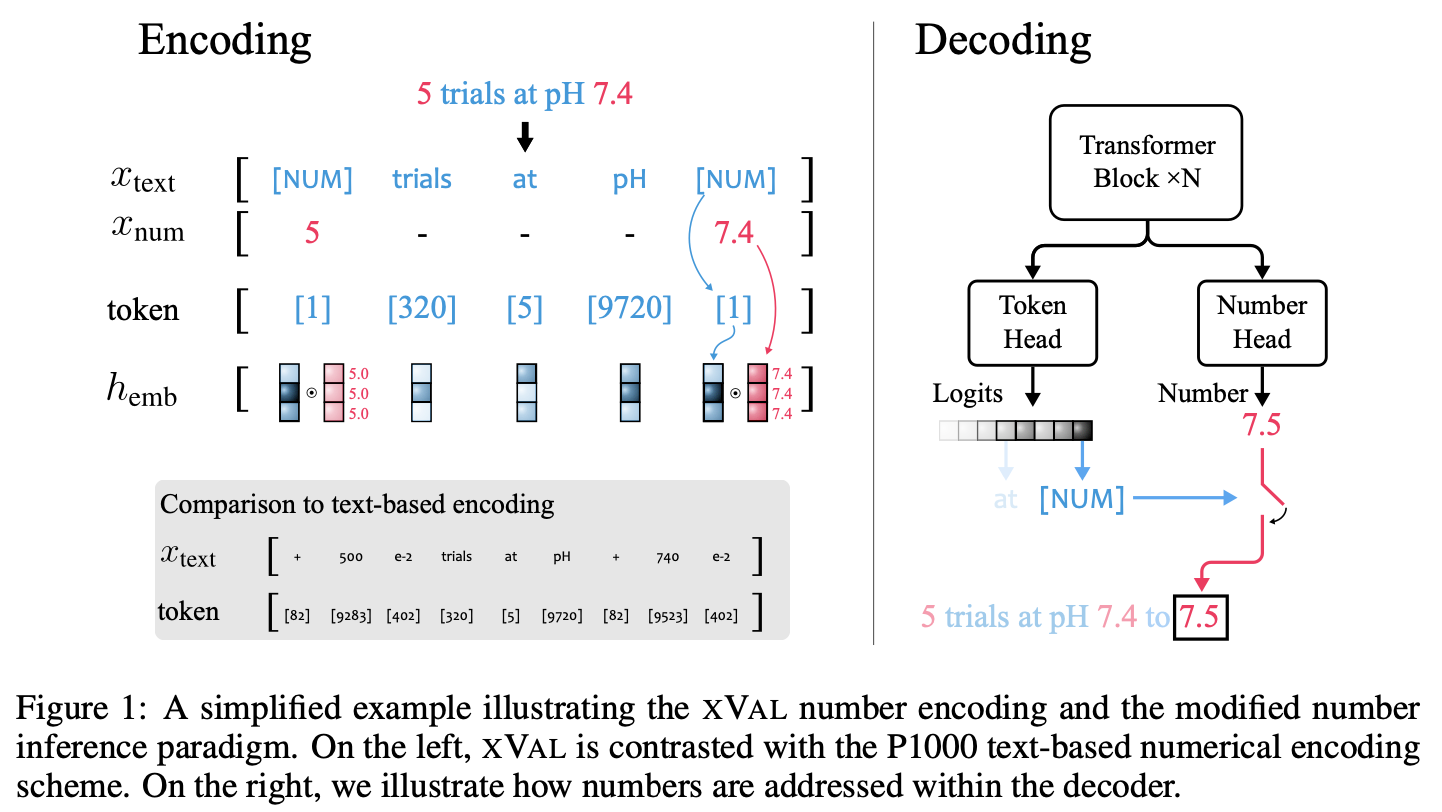

# Import Data:

From all the Datasets proposed by the authors of the paper, I have chosen the one related to planetary motion. This is a synthetic Dataset, which is composed by some planetary simulations generated by the <font color='olive'>REBOUND</font> library.
The Dataset have been obtained by using the code provided by the authors of the repository. Each Dataset partition have been saved into a file inside Google Drive.

In [ ]:
"""
All data are obtained through a simulation that uses REBOUND library
"""
training_data = Dataset.from_text(drive_path + '/training')
test_data = Dataset.from_text(drive_path + '/test')
val_data = Dataset.from_text(drive_path + '/validation')


print(training_data)
print('\n')
print(test_data)
print('\n')
print(val_data)
print('\n')
# what the first 100 characters of the 1st row look like:
print(training_data['text'][0][:100])

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 300000
})


Dataset({
    features: ['text'],
    num_rows: 125000
})


Dataset({
    features: ['text'],
    num_rows: 10000
})


{'description':{'planet0':{'m':3.8050266189989066,'a':1.2661963245440728,'e':0.5255877225805115},'pl


The Dataset partitions have been imported using Hugging Face's <font color="olive">datasets</font> library and each of them is saved as
***datasets.arrow_dataset.Dataset***. These structure have a columnary layout and we can access data through the <font color="orange">'text'</font> column.

In [ ]:
def keys_extraction(text):
    # the Dataset is characterized by a specific pattern. All words are contained between ' '
    regex = r"'(.*?)'"
    return re.findall(regex, text)

In [ ]:
"""
As previously stated in the Report, the Dataset is composed by few words and a lot of numbers.
We are going to see how many different words we have inside our Dataset (some of them are fixed, while other can be specified
during the simulation like the number of planets)

"""

keys_occurrences = training_data.map( # by doing this, we will have all keys (words)
    lambda x: {"keys": keys_extraction(x['text'])}, # create a column of keys
    remove_columns=['text'] # get rid of the text column
)

# inside keys we have all the occurrences of the words
# now we create a set of them and see how many different words we have inside our dataset
keys = set()
for row in keys_occurrences['keys']:
    for word in row:
        keys.add(word)

print(f"We have a Total of {len(keys)} Keys, which are: {keys}")

# count the number of occurrences of all the keys
m = 0
desc = 0
pl0 = 0
pl1 = 0
pl2 = 0
pl3 = 0
pl4 = 0

for row in keys_occurrences['keys']:
    m += row.count('m')
    desc += row.count('description')
    pl0 += row.count('planet0')
    pl1 += row.count('planet1')
    pl2 += row.count('planet2')
    pl3 += row.count('planet3')
    pl4 += row.count('planet4')

print(f"Number of occurrences of all the keys 'm', 'a', 'e': {m}")
print(f"Number of occurrences of all the keys 'description', 'data', 'stepsize': {desc}")
print(f"Number of occurrences of all the keys 'planet0': {pl0}, 'planet1': {pl1}, 'planet2': {pl2}, 'planet3': {pl3}, 'planet4': {pl4}")

Map:   0%|          | 0/300000 [00:00<?, ? examples/s]

We have a Total of 11 Keys, which are: {'m', 'data', 'description', 'planet3', 'planet1', 'planet0', 'e', 'planet4', 'planet2', 'stepsize', 'a'}
Number of occurrences of all the keys 'm', 'a', 'e': 1049975
Number of occurrences of all the keys 'description', 'data', 'stepsize': 300000
Number of occurrences of all the keys 'planet0': 300000, 'planet1': 300000, 'planet2': 225177, 'planet3': 149920, 'planet4': 74878


As we can see from the previous numbers, each simulation is composed by one occurrence of the keys <font color="orange">description</font> , <font color='orange'>data</font>  and <font color='orange'>stepsize</font> .
We also have a minimum of 2 planets (<font color='orange'>planet0</font> and <font color='orange'>planet1</font>) to a maximum of 4 for each simulation. Frome the above numbers, we can see that around **75%** of the simulations (samples) have at least 3 planets and that only the **25%** of the total have 5 planets. Each planet involved in the simulation is described by 3 keys <font color='orange'>m</font>, <font color='orange'>a</font>, <font color='orange'>e</font> that represent the mass, the length of the major semi-axis and the eccentricity.

In [ ]:
def numbers_extraction(data):
    # extract all numbers
    regex = r"(-?[0-9]\.[0-9]*)"
    return re.findall(regex, data)

def numbers_substitution(data):
    # replace all numbers with [NUM] token
    regex = r"(-?[0-9]\.[0-9]*)"
    return re.sub(regex, '[NUM]', data)

def numerical_processing(data):

    # numbers extraction and substitution
    numbers = data.map(
    lambda x: {'nums': numbers_extraction(x['text']), 'no_nums': numbers_substitution(x['text'])},
    remove_columns=['text']
    )

    return numbers

In [ ]:
processed_numbers_train = numerical_processing(training_data)
processed_numbers_test = numerical_processing(test_data)
processed_numbers_val = numerical_processing(val_data)

Map:   0%|          | 0/300000 [00:00<?, ? examples/s]

Map:   0%|          | 0/125000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
print(f"First Hundred characters after replacing numbers: {processed_numbers_train['no_nums'][0][:100]}")
print(f"Numbers replaced by [NUM]: {processed_numbers_train['nums'][0][:6]}")

First Hundred characters after replacing numbers: {'description':{'planet0':{'m':[NUM],'a':[NUM],'e':[NUM]},'planet1':{'m':[NUM],'a':[NUM],'e':[NUM]},
Numbers replaced by [NUM]: ['3.8050266189989066', '1.2661963245440728', '0.5255877225805115', '2.9670398477427886', '1.5323926490881454', '0.9370771996085853']


Since we are interested in the numerical values, we have to extract and substitute them with our previously defined placeholder <font color="yellow">[NUM]</font>. This have been achieved by exploiting the function ***map*** and the capabilities of **Regular Expressions**. The regex that have been used helps us to localize and substitute each number, which are all decimal and they can be positive or negative. Since the regex is suited for decimal values we are not going to select any number related to the planet keys.

# Tokenizer:

Use BPE algorithm:

1. Initialize the vocabulary with all the bytes or characters in the text corpus
2. Calculate the frequency of each byte or character in the text corpus.
3. Repeat the following steps until the desired vocabulary size is reached:
    4. Find the most frequent pair of consecutive bytes or characters in the text corpus
    5. Merge the pair to create a new subword unit.
    6. Update the frequency counts of all the bytes or characters that contain the merged pair.
7. Add the new subword unit to the vocabulary.

Since the Dataset is composed by 11 recurrent words and parentheses, the vocabulary of the Tokenizer have been populated accordingly to this. The Tokenizer has been implemented by using <font color="olive">PreTrainedTokenizerFast</font> from Hugging Face.

In [ ]:
"""
As we have seen, the samples are composed mostly by the same words.
We have to create the vocabulary of our Tokenizer :
"""
# each word of the keys inside our data is between ' ' and before a : (e.g 'description':)

vocabulary = [
    "'description':",
    "'data':",
    "'stepsize':",
    "'planet0':",
    "'planet1':",
    "'planet2':",
    "'planet3':",
    "'planet4':",
    "'m':",
    "'a':",
    "'e':",
    "[",
    "[[",
    "[[[",
    "]",
    "]]",
    "]]]",
    "{",
    "}",
    ",",
    "],[",
    "]],[[",
    "]]],[[[",
]

tokenizer = Tokenizer(models.BPE(vocab={}, merges=[]))
tokenizer.add_tokens(vocabulary)
tokenizer.add_special_tokens(['[NUM]', '[PAD]', '[UNK]', '[END]'])
# since all words are lowercase and there isn't any accent or space, we don't need to apply any normalization
tokenizer.save(drive_path + '../src/my_tokenizer.json')

In [ ]:
my_tokenizer = PreTrainedTokenizerFast(
    tokenizer_file='/content/drive/MyDrive/NN/src/my_tokenizer.json',
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

In [ ]:
my_tokenizer.vocab

{"'m':": 8,
 '{': 17,
 ']]]': 16,
 "'planet3':": 6,
 '[[[': 13,
 '[SEP]': 27,
 '[NUM]': 23,
 "'data':": 1,
 '[UNK]': 25,
 '[': 11,
 ']]],[[[': 22,
 "'a':": 9,
 '[MASK]': 29,
 ']]': 15,
 "'planet0':": 3,
 "'e':": 10,
 "'planet4':": 7,
 "'planet1':": 4,
 "'description':": 0,
 ']],[[': 21,
 '[PAD]': 24,
 '[CLS]': 28,
 ',': 19,
 '[END]': 26,
 '}': 18,
 ']': 14,
 "'stepsize':": 2,
 '[[': 12,
 "'planet2':": 5,
 '],[': 20}

In [ ]:
enc = my_tokenizer.encode(processed_numbers_train['no_nums'][0][:100])
print(enc)

[17, 0, 17, 3, 17, 8, 23, 19, 9, 23, 19, 10, 23, 18, 19, 4, 17, 8, 23, 19, 9, 23, 19, 10, 23, 18, 19]


In [ ]:
dec = my_tokenizer.decode(enc)
print(dec)

{ 'description': { 'planet0': {'m': [NUM], 'a': [NUM], 'e': [NUM] }, 'planet1': {'m': [NUM], 'a': [NUM], 'e': [NUM] },


In [ ]:
def tokenization(data):
    # this function return the tokenized dataset inside the column "token_ids"
    # convert all numbers represented in string to float values
    return data.map(
        lambda x: {"token_ids": my_tokenizer.encode(x['no_nums'], max_length=1024, truncation=True), 'nums': [float(num) for num in x['nums']]}
    )


tokenized_data_train = tokenization(processed_numbers_train)
tokenized_data_test = tokenization(processed_numbers_test)
tokenized_data_val = tokenization(processed_numbers_val)

Map:   0%|          | 0/300000 [00:00<?, ? examples/s]

Map:   0%|          | 0/125000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
print(f"20 tokenized characters: {tokenized_data_train['token_ids'][0][:20]}")

20 tokenized characters: [17, 0, 17, 3, 17, 8, 23, 19, 9, 23, 19, 10, 23, 18, 19, 4, 17, 8, 23, 19]


In [ ]:
# save data

tokenized_data_train.save_to_disk(drive_path + '/tokenized/tokenized_data_train')
tokenized_data_test.save_to_disk(drive_path + '/tokenized/tokenized_data_test')
tokenized_data_val.save_to_disk(drive_path + '/tokenized/tokenized_data_val')

Saving the dataset (0/7 shards):   0%|          | 0/300000 [00:00<?, ? examples/s]

Saving the dataset (0/3 shards):   0%|          | 0/125000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

# Model:


Here is the definition of a <font color="yellow">Collator</font>, which is a function used by the DataLoader to prepare data for training. One of the main problem that we have to solve is the variable length that we may find in our samples. This is solved by applying some <font color="orange">**padding**</font>. In my case the Collator gives me back two tensors:

* <font color="orange">***x_id_pad***</font> which contains all token ids with the relative padding

* <font color="orange">***x_num_pad***</font> which contains all numbers in the position in which x_id_pad has
  the <font color="yellow">[NUM]</font> token id.

I need to introduce an **Attention Mask** to differentiate between actual tokens and padding tokens.

In [ ]:
# import tokenized data directly
tokenized_data_train = Dataset.load_from_disk(drive_path + '/tokenized/tokenized_data_train')
tokenized_data_test = Dataset.load_from_disk(drive_path + '/tokenized/tokenized_data_test')
tokenized_data_val = Dataset.load_from_disk(drive_path + '/tokenized/tokenized_data_val')

In [209]:
"""
Definition of a Collator function to be used by the DataLoader in order to prepare our data for training
"""

def collator(batch):
    # translation to pytorch tensor
    x_id = [torch.tensor(sample['token_ids']) for sample in batch]  # all token ids
    x_num = [torch.tensor(sample['nums']) for sample in batch]      # all original numbers

    # since we have variable length for each simulation, it might be a good idea to extract the maximum one

    max_length = max([len(sample) for sample in x_id])

    # add padding to all samples in order to have them of equal length
    # my_tokenizer.pad_token_id aka 24
    x_id_pad = torch.full((len(batch), max_length), fill_value=my_tokenizer.pad_token_id, dtype=torch.long)
    for idx, sample in enumerate(x_id):
        x_id_pad[idx, :len(sample)] = sample.clone().detach() # copy that sample

    # add padding to all original_numbers in order to have them of equal length
    # when you don't have a number you will have -100
    x_num_pad = torch.full((len(batch), max_length), fill_value=-100, dtype=torch.float)
    for i, sample in enumerate(x_id):     # extract all original number from each sample (row)
        for j, token_id in enumerate(sample):   # extract all numbers from each sample (row)
        # if that value is a number ([NUM] token id = 23) and your index is not out of bounds for the numbers tensor
            if token_id==23 and j < len(x_num[i]):
                x_num_pad[i, j] = x_num[i][j]

    # compute the attention mask --> 0 when I have padding, 1 otherwise
    att_mask = (x_id_pad != my_tokenizer.pad_token_id).long()

    # x_id_pad contains all token ids with padding
    # x_num_pad contains all numbers in the correct position with padding
    # att_mask contains the attention mask
    return x_id_pad, x_num_pad, att_mask

# Create DataLoaders
train_loader = DataLoader(tokenized_data_train, batch_size=12, collate_fn=collator, shuffle=True)
test_loader = DataLoader(tokenized_data_test, batch_size=12, collate_fn=collator, shuffle=True)
val_loader = DataLoader(tokenized_data_val, batch_size=12, collate_fn=collator, shuffle=True)

All the paper implementations, regardless of the numerical encodings, have used a language model with the main feature as **GPT-2**.
Since all numbers have been replace by the same token <font color="yellow">[NUM]</font>, we have lost the numerical information. This means that the Token Head of the model does not carry any information about the number value. A new <font color="orange">***Number Head***</font> with a scalar output is needed to recover the numerical value associated with each istance of the <font color="yellow">[NUM]</font> token.
This means that when the generated token is <font color="yellow">[NUM]</font>, we have to look at the number head to fill the related numerical value.

In [181]:
"""
Since I am interested in the numerical part of the problem, I will use a pre-trained version of GPT2 and includes a numerical head
in order to predict numerical values.
"""

class NumericalHead(torch.nn.Module):
    def __init__(self, gpt2):
        super(NumericalHead, self).__init__()
        self.token_head = gpt2
        self.num_head = torch.nn.Sequential(
            torch.nn.Linear(gpt2.config.n_embd, 384),
            torch.nn.GELU(),
            torch.nn.Linear(384, 1)
        )

    def forward(self, x_ids, attention_mask=None):
        output = self.token_head(x_ids, attention_mask=attention_mask)
        hidden_states = output.last_hidden_state # hidden states from the last layer of GPT-2 for each token in the sequence

        # create a numerical mask --> 1 when you have a number, 0 otherwise
        # expand the tensor dimension to match the ones of the hiddend_state
        mask = (x_ids == 23).unsqueeze(-1).expand(hidden_states.size())

        hidden_states_masked = hidden_states * mask.float() # by doing this you obtain the numbers

        num_preds = self.num_head(hidden_states_masked).squeeze(-1)

        return num_preds

In [182]:
# import the pre-trained version of gpt2 from Hugging Face
gpt2 = GPT2Model.from_pretrained('gpt2')
gpt2.resize_token_embeddings(len(my_tokenizer)) # resize the token_embeddings dimension since our vocabulary is smaller

Embedding(30, 768)

In [183]:
num_head = NumericalHead(gpt2)
num_head = num_head.cuda()

In [184]:
num_head

NumericalHead(
  (token_head): GPT2Model(
    (wte): Embedding(30, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (num_head): Sequential(
    (0): Linear(in_features=768, out_features=384, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=384, out_features=1, bias=True)
  )
)

In [185]:
"""
    Training Loop
"""
loss_cnt = [] # container to store training loss values
optimizer = torch.optim.Adam(num_head.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()
n_epochs = 15

for epoch in tqdm(range(n_epochs)):
    num_head.train()
    num_batches = 0
    for batch in train_loader:

        # cap the number of batches to have a faster training
        if num_batches > 100:
            break

        x_ids, x_nums, att_mask = batch

        # use GPU
        x_ids = x_ids.cuda()        # token ids
        x_nums = x_nums.cuda()      # numbers (-100 when you don't have a number in x_ids)
        att_mask = att_mask.cuda()  # attention_mask

        num_preds = num_head(x_ids, att_mask)

        # extract position where you have a number
        numerical_values_positions = x_nums != -100 # equal to x_ids == 23 ([NUM] token_id)

        # loss computation (use MSE as paper) only between numerical values
        loss = criterion(num_preds[numerical_values_positions], x_nums[numerical_values_positions])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        num_batches += 1

        loss_cnt.append(loss.item())

    num_head.eval()
    valid_loss = []
    num_val = 0
    with torch.no_grad():
        for batch in val_loader:

            if num_val > 100:
                break

            x_ids, x_nums, att_mask = batch

            # use GPU
            x_ids = x_ids.cuda()        # token ids
            x_nums = x_nums.cuda()      # numbers (-100 when you don't have a number in x_ids)
            att_mask = att_mask.cuda()  # attention_mask

            num_preds = num_head(x_ids, att_mask)

            # extract position where you have a number
            numerical_values_positions = x_nums != -100 # equal to x_ids == 23 ([NUM] token_id)

            val = criterion(num_preds[numerical_values_positions], x_nums[numerical_values_positions])

            valid_loss.append(val.item())
            num_val += 1

    if epoch % 5 == 0:
        # save one checkpoint each 5 epochs
        check = {
            "model": num_head.state_dict(),
            "optim": optimizer.state_dict(),
            "train_loss": loss_cnt,
        }

        torch.save(check, '/content/drive/MyDrive/NN/checkpoints/num_head_'+str(epoch)+'.pt')

    print(f"Epoch {epoch}, Average Training Loss: {np.array(loss_cnt).mean():.4f}, Average Validation Loss: {np.array(valid_loss).mean():.4f}")

# save final model
check = {
            "model": num_head.state_dict(),
            "optim": optimizer.state_dict(),
            "train_loss": loss_cnt,
        }

torch.save(check, '/content/drive/MyDrive/NN/checkpoints/num_head_final.pt')

  7%|▋         | 1/15 [01:48<25:15, 108.26s/it]

Epoch 0, Average Training Loss: 1.5904, Average Validation Loss: 1.5152


 13%|█▎        | 2/15 [03:34<23:11, 107.07s/it]

Epoch 1, Average Training Loss: 1.5479, Average Validation Loss: 1.4918


 20%|██        | 3/15 [05:20<21:16, 106.40s/it]

Epoch 2, Average Training Loss: 1.5367, Average Validation Loss: 1.5103


 27%|██▋       | 4/15 [07:05<19:27, 106.11s/it]

Epoch 3, Average Training Loss: 1.5286, Average Validation Loss: 1.4899


 33%|███▎      | 5/15 [08:51<17:39, 105.96s/it]

Epoch 4, Average Training Loss: 1.5190, Average Validation Loss: 1.4923


 40%|████      | 6/15 [10:40<16:03, 107.04s/it]

Epoch 5, Average Training Loss: 1.5149, Average Validation Loss: 1.5069


 47%|████▋     | 7/15 [12:26<14:13, 106.66s/it]

Epoch 6, Average Training Loss: 1.5062, Average Validation Loss: 1.4913


 53%|█████▎    | 8/15 [14:12<12:24, 106.31s/it]

Epoch 7, Average Training Loss: 1.5036, Average Validation Loss: 1.4889


 60%|██████    | 9/15 [15:58<10:37, 106.22s/it]

Epoch 8, Average Training Loss: 1.5043, Average Validation Loss: 1.4869


 67%|██████▋   | 10/15 [17:43<08:49, 105.98s/it]

Epoch 9, Average Training Loss: 1.5024, Average Validation Loss: 1.4920


 73%|███████▎  | 11/15 [19:31<07:06, 106.59s/it]

Epoch 10, Average Training Loss: 1.4997, Average Validation Loss: 1.4830


 80%|████████  | 12/15 [21:16<05:18, 106.06s/it]

Epoch 11, Average Training Loss: 1.4998, Average Validation Loss: 1.4889


 87%|████████▋ | 13/15 [23:02<03:32, 106.18s/it]

Epoch 12, Average Training Loss: 1.5006, Average Validation Loss: 1.4765


 93%|█████████▎| 14/15 [24:48<01:45, 105.96s/it]

Epoch 13, Average Training Loss: 1.5007, Average Validation Loss: 1.5049


100%|██████████| 15/15 [26:33<00:00, 106.23s/it]

Epoch 14, Average Training Loss: 1.5004, Average Validation Loss: 1.5016


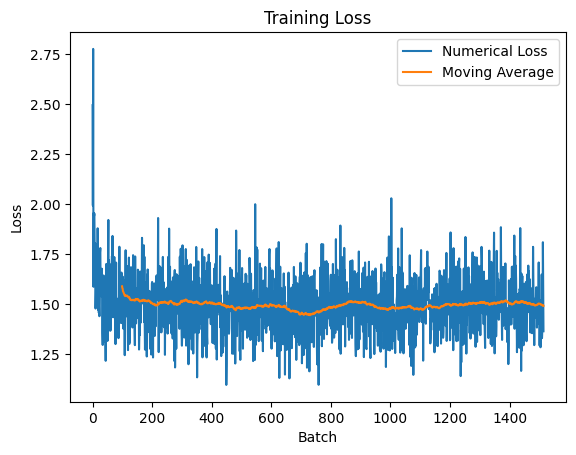

In [186]:
plt.plot(loss_cnt, label='Numerical Loss')
plt.plot(pd.Series(loss_cnt).rolling(100).mean(), label='Moving Average')
plt.legend()
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

The Batch Size of each DataLoaders has been chosen accordingly to GPU capabilities of Colab-Pro. With this settings I have reached the use of <font color="green">39.3 Gb</font> over a total of 40 Gb (A100 GPU).
I have tried different numbers of epochs and batch sizes (this have been used to reduce training time) but unfortunately the model does not reach better performances than those obtained here.
As previously stated, there are some differences between mine and their implementation.
They have trained from scratch a GPT2-like model composed by 6 Heads, while I have used the pre-trained version of GPT2 which has a total of 12 Heads. The Implementation of the Numerical Head is the same but there is a huge different on training time and GPU usage since they have trained together the architecture with the Numerical Head.
Another important difference is that samples with a bigger length of 1024 have been truncated since the maximum length taken in input by the pre-trained version of GPT-2 is 1024.

# Evaluation:

In [ ]:
# if you are evaluating in another moment you need to load your checkpoints and import gpt2:

check = torch.load('/content/drive/MyDrive/NN/checkpoints/num_head_final.pt')

gpt2 = GPT2Model.from_pretrained('gpt2')
gpt2.resize_token_embeddings(len(my_tokenizer))

num_head = NumericalHead(gpt2)
num_head.load_state_dict(check['model'])
num_head = num_head.cuda()

Since the first and second planet are in all simulations, I will test the Numerical Predictions on their attributes.
As previously seen, each samples belonging to our dataset has this structure:

` {'description':{'planet0':{'m':[NUM],'a':[NUM],'e':[NUM]},'planet1':{'m':[NUM],'a':[NUM],'e':[NUM]}, . . . `

This means that the first number, representing the mass of the first planet, is located at index 6 (starting from 0), since we have 6 token before it.

In [210]:
num_samples = 99
num_head.eval()
with torch.no_grad():
    samples_evaluated = 0
    l_true = []
    l_pred = []
    for batch in test_loader:

        if samples_evaluated > num_samples :
            break

        x_ids, x_nums, att_mask = batch

        #GPU

        x_ids = x_ids.cuda()
        x_nums = x_nums.cuda()
        att_mask = att_mask.cuda()

        num_preds = num_head(x_ids, att_mask)

        # extract numbers

        """
            Since I will test the perfomances on the first 2 planets attributes, we need only the first 6 numbers.
            However, taking num_preds = num_preds[numerical_values_positions] will flatten the output.
            This means that you cannot get the first 6 numbers of each samples without knowing the length of each sample.
            I am evaluating only the first 2 planet so the initial order of the samples will be the same for each sample.
            I will select the first 26 elements of each samples and then extract the numbers
        """
        x_nums_planet01 = x_nums[:,:26] # real values (first 26 characters)
        idx = x_nums_planet01 != -100
        x_nums_planet01 = x_nums_planet01[idx] # real values (only numbers)

        num_preds_planet01 = num_preds[:,:26] # predictions (first 26 characters)
        num_preds_planet01 = num_preds_planet01[idx] # predictions (only numbers)

        l_true.append(x_nums_planet01.cpu().numpy())
        l_pred.append(num_preds_planet01.cpu().numpy())

        samples_evaluated += 1

# by doing this, we extract the mass, the eccentricity and the length of the major semi-axis of planet0 and planet1

Here I process the lists in order to transform them into 4 <font color="olive">Pandas</font> DataFrames:

* One for the real and predicted value of planet0
* One for the real and predicted value of planet1

In [211]:
# flatten the values into a list of 7200 values --> before you had 100 list of 72 values each
flattened_true = [item for sublist in l_true for item in sublist]
flattened_pred = [item for sublist in l_pred for item in sublist]

# reshape the list into a (1200,6)
reshaped_true = [flattened_true[i:i + 6] for i in range(0, len(flattened_true), 6)]
reshaped_pred = [flattened_pred[i:i + 6] for i in range(0, len(flattened_pred), 6)]

# since all simulations have planet0 and 1 we will have inside even positions planet0 elements and planet1 elements in odd positions

"""planet0"""

true_planet0 = pd.DataFrame([row[:3] for row in reshaped_true]) # (1200,3)
pred_planet0 = pd.DataFrame([row[:3] for row in reshaped_pred]) # (1200,3)


"""planet1"""

true_planet1 = pd.DataFrame([row[3:] for row in reshaped_true]) # (1200,3)
pred_planet1 = pd.DataFrame([row[3:] for row in reshaped_pred]) # (1200,3)


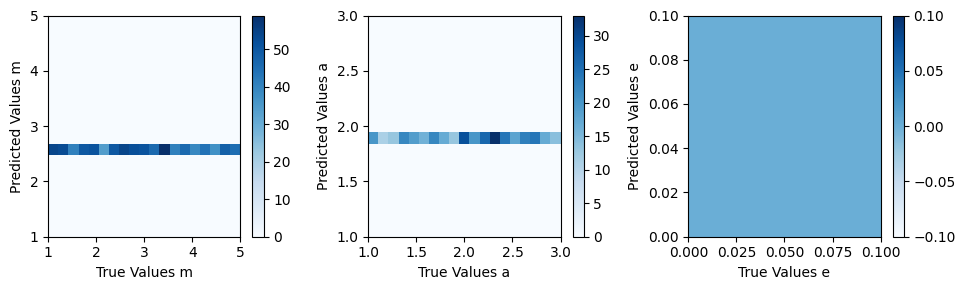

In [231]:
# Planet0
charact = ['m', 'a', 'e']
bins = [(np.linspace(1,5,20),np.linspace(1,5,20)), (np.linspace(1,3,20),np.linspace(1,3,20)), (np.linspace(0,0.1,20),np.linspace(0,0.1,20))]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,3), tight_layout=True)
for i in range(3):
    ax = axs[i]
    h = ax.hist2d(true_planet0[i], pred_planet0[i], bins=bins[i], cmap='Blues')
    ax.set_xlabel('True Values '+ str(charact[i]))
    ax.set_ylabel('Predicted Values '+ str(charact[i]))
    fig.colorbar(h[3])
plt.show()

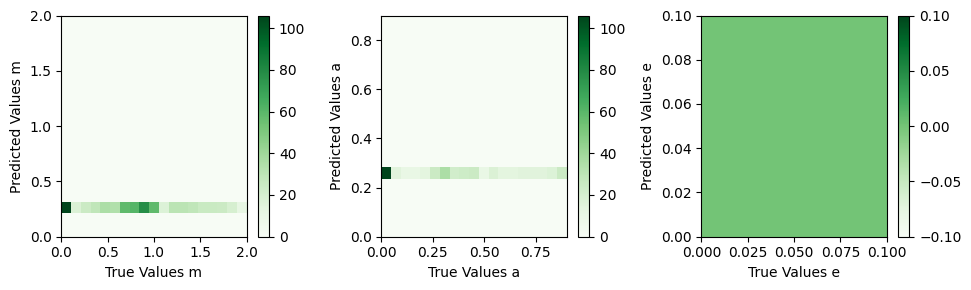

In [230]:
# Planet1
charact = ['m', 'a', 'e']
bins = [(np.linspace(0,2,20),np.linspace(0,2,20)), (np.linspace(0,0.9,20),np.linspace(0,0.9,20)), (np.linspace(0,0.1,20),np.linspace(0,0.1,20))]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,3), tight_layout=True)
for i in range(3):
    ax = axs[i]
    h = ax.hist2d(true_planet1[i], pred_planet1[i], bins=bins[i], cmap='Greens')
    ax.set_xlabel('True Values '+ str(charact[i]))
    ax.set_ylabel('Predicted Values '+ str(charact[i]))
    fig.colorbar(h[3])
plt.show()

As can we see from the previous plots, even if the Loss behaviour is similar to the one obtained from the authors in the paper, the Numerical Head remains stuck into small intervals of values when it predicts the attributes of planet0 and planet1. The author obtained the same behaviour for the mass attributes. However the length of the major semi-axis is better predicted and as a consequence the 2D Histogram of <font color="orange">a</font> shows a better correlation.
The eccentricity values are really small with respect to the other attributes and we can see that in both cases (mine and authors) we get bigger values out of the correct range.
I have taken as reference for the comparison their file  *x_val_demo.ipynb* .
These problems that I have found may be related to the fact that I have used a bigger (and pre-trained) architecture while they have trained it from scratch directly with the additional Numerical Head. Another huge is difference is that I needed to truncate the samples with a bigger length than 1024 due to the pre-trained architecture.
Another things that could be changed is the vocabulary of the token. I have inserted directly the words without training it from scratch since our Dataset have a specific structure. It may be a good idea trying the xVal tokenization approach with other structure-less dataset and see what happens.